# SIGNATURE VERIFICATION

In [2]:
########### THINNING ALGORITHM #############

from scipy import weave
import numpy as np
import cv2

def _thinningIteration(im, iter):
    I, M = im, np.zeros(im.shape, np.uint8)
    expr = """
    for (int i = 1; i < NI[0]-1; i++) {
        for (int j = 1; j < NI[1]-1; j++) {
            int p2 = I2(i-1, j);
            int p3 = I2(i-1, j+1);
            int p4 = I2(i, j+1);
            int p5 = I2(i+1, j+1);
            int p6 = I2(i+1, j);
            int p7 = I2(i+1, j-1);
            int p8 = I2(i, j-1);
            int p9 = I2(i-1, j-1);

            int A  = (p2 == 0 && p3 == 1) + (p3 == 0 && p4 == 1) +
                     (p4 == 0 && p5 == 1) + (p5 == 0 && p6 == 1) +
                     (p6 == 0 && p7 == 1) + (p7 == 0 && p8 == 1) +
            (p8 == 0 && p9 == 1) + (p9 == 0 && p2 == 1);
            int B  = p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9;
            int m1 = iter == 0 ? (p2 * p4 * p6) : (p2 * p4 * p8);
            int m2 = iter == 0 ? (p4 * p6 * p8) : (p2 * p6 * p8);

            if (A == 1 && B >= 2 && B <= 6 && m1 == 0 && m2 == 0) {
                M2(i,j) = 1;
            }
        }
    } 
    """

    weave.inline(expr, ["I", "iter", "M"])
    return (I & ~M)


def thinning(src):
    dst = src.copy() / 255
    prev = np.zeros(src.shape[:2], np.uint8)
    diff = None

    while True:
        dst = _thinningIteration(dst, 0)
        dst = _thinningIteration(dst, 1)
        diff = np.absolute(dst - prev)
        prev = dst.copy()
        if np.sum(diff) == 0:
            break

    return dst * 255

############# ESCALAMIENTO #############
# Metodo que permite escalar la imagen a un tamaño por default(100)
# para que todas las imagenes posean el mismo tamaño
def scale(image, height=500):
    # Obtenemos las filas y columnas
    original_h, original_w = np.float32(image.shape[:2])
    # Calculamos el ancho que tendra con respecto al alto(100)
    width = int( height * ( original_w / original_h ) )
    # Escalamos la imagen
    image_scaled = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
    # Retornamos la imagen escalada
    return image_scaled

def normalize(image):
    # dilating image
    img = image.copy()
    kernel = np.ones((20,20), np.uint8)
    img = cv2.erode(img, kernel, iterations = 1)

    # Binarization
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    _,contours,hierarchy = cv2.findContours(255 - thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Buscamos el contorno mas grande
    max_area_contour = cv2.contourArea(contours[0])
    max_index = 0
    for index, contour in enumerate(contours):
        index_area_contour = cv2.contourArea(contour)
        if index_area_contour > max_area_contour:
            max_area_contour = index_area_contour
            max_index = index

    cnt = contours[max_index]    

    # Bounding Rect
    x,y,w,h = cv2.boundingRect(cnt)

    # Cropping
    image = image[y:y+h,x:x+w]
    return image

############# PREPROCESSING #############
def preprocess(image, showProcess=False):
    #GrayScale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if showProcess:
        cv2.imshow(' GrayScale', image)
        cv2.waitKey(0)
        
    #Scaling 1
    image = scale(image)
    if showProcess:
        cv2.imshow(' Scaled 1', image)
        cv2.waitKey(0)

    # Normalizing
    image = normalize(image);
    if showProcess:
        cv2.imshow(' Normalized', image)
        cv2.waitKey(0)
        
    #Scaling 2
    image = scale(image)
    if showProcess:
        cv2.imshow(' Scaled 2', image)
        cv2.waitKey(0)

    # Binarizacion 1
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    if showProcess:
        cv2.imshow(' Binarizacion inv 1', image)
        cv2.waitKey(0)
    
    # Dilation
    #image = cv2.dilate(image, np.ones((5,5),np.uint8))
    #if showProcess:
    #    cv2.imshow(' Erosino ', image)
    #    cv2.waitKey(0)
    
    # Erosion
    #image = cv2.erode(image, np.ones((7,7),np.uint8))
    #if showProcess:
    #    cv2.imshow(' Erosino ', image)
    #    cv2.waitKey(0)
    
    # Thinning
    image = thinning(image)
    if showProcess:
        cv2.imshow(' Thining', image)
        cv2.waitKey(0)
        
    # Binarizacion inv 2
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    if showProcess:
        cv2.imshow(' Binarizacion inv 2', image)
        cv2.waitKey(0)
    
    return image

def dilatex5(image):
    # DILATION 
    image_color_black = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_color_red = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_color_green= cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_color_blue = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    image_color_black[image == 0] = [0, 0, 0]
    image_color_red[image == 0]   = [0, 0, 255]
    image_color_green[image == 0] = [0, 255, 0]
    image_color_blue[image == 0]  = [255, 0, 0]

    kernel_3 = np.ones((3,3), np.uint8)
    kernel_6 = np.ones((6,6), np.uint8)
    kernel_10 = np.ones((10,10), np.uint8) 
    kernel_16 = np.ones((16,16), np.uint8)

    image_3 = cv2.erode(image_color_black, kernel_3, iterations = 1)
    image_6 = cv2.erode(image_color_red, kernel_6, iterations = 1)
    image_10 = cv2.erode(image_color_green, kernel_10, iterations = 1)
    image_16 = cv2.erode(image_color_blue, kernel_16, iterations = 1)

    #cv2.imshow("Kernel 3", image_3)
    #cv2.imshow("Kernel 6", image_6)
    #cv2.imshow("Kernel 10", image_10)
    #cv2.imshow("Kernel 16", image_16)

    # FUSION
    img_fusion_1 = cv2.bitwise_and(image_16,image_10)
    img_fusion_1[cv2.threshold(cv2.cvtColor(img_fusion_1, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)[1] == 0] = [0, 255, 0]

    img_fusion_2 = cv2.bitwise_and(img_fusion_1, image_6)
    img_fusion_2[cv2.threshold(cv2.cvtColor(img_fusion_2, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)[1] == 0] = [0, 0, 255]

    img_fusion_3 = cv2.bitwise_and(img_fusion_2, image_3)

    return img_fusion_3


def obtenerFeatures(image):
    # GEOMETRIC FEATURES

    imHeight, imWidth = np.float32(image.shape[:2])
    totalPixels = imHeight*imWidth

    # Aspect Ratio
    aspectRatio = imHeight / imWidth
    #print 'Aspect Ratio : ', aspectRatio

    # Density Ratio
    whitePixelsHalfLeft  = cv2.countNonZero(image[:,:image.shape[1]/2])
    signaturePixelsHalfLeft = totalPixels/2 - whitePixelsHalfLeft
    whitePixelsHalfRight = cv2.countNonZero(image[:,image.shape[1]/2:])
    signaturePixelsHalfRight = totalPixels/2 - whitePixelsHalfRight

    densityRatio = signaturePixelsHalfLeft / whitePixelsHalfRight

    #print 'Density Ratio : ' , densityRatio

    # Ocupancy Ratio
    ## Negro 0 (cero)
    ## Otros(Blanco) NonZero
    totalWhitePixels = cv2.countNonZero(image)
    signaturePixels = totalPixels-totalWhitePixels
    occupancyRatio = signaturePixels / totalWhitePixels
    #print 'Occupancy Ratio : ', occupancyRatio

    # Harris Corners / GoodFeatures to Track
    #cornersArr = cv2.cornerHarris(image, 3, 3, 0.05)
    cornersArr = cv2.goodFeaturesToTrack(image, 500, 0.01, 15)
    corners = len(cornersArr)
    #print 'Corners : ' , corners
    
    # Imagen usada como base para comparar contra otras nuevas
    img_base = cv2.imread('images/signatures/drsc/legit_1_x5.jpg')
    img_entry = dilatex5(image)
    img_merged = cv2.bitwise_xor(img_base,img_entry)

    #cv2.imshow('im2',img_base)
    #cv2.imshow('im3',img_entry)
    #cv2.imshow('merged',img_merged)

    # NEGRO
    BLACK_MIN = np.array([0, 0, 0], np.uint8)
    BLACK_MAX = np.array([50, 50, 50], np.uint8)
    dst_black = cv2.inRange(img_merged, BLACK_MIN, BLACK_MAX)
    #cv2.imshow('Black',dst_black)
    no_black = cv2.countNonZero(dst_black)
    #print('The number of black pixels is: ' + str(no_black))

    # ROJO
    RED_MIN = np.array([0, 0, 200], np.uint8)
    RED_MAX = np.array([50, 50, 255], np.uint8)
    dst_red = cv2.inRange(img_merged, RED_MIN, RED_MAX)
    #cv2.imshow('Red',dst_red)
    no_red = cv2.countNonZero(dst_red)
    #print('The number of red pixels is: ' + str(no_red))

    # VERDE
    GREEN_MIN = np.array([0, 200, 0], np.uint8)
    GREEN_MAX = np.array([50, 255, 50], np.uint8)
    dst_green = cv2.inRange(img_merged, GREEN_MIN, GREEN_MAX)
    #cv2.imshow('Green',dst_green)
    no_green = cv2.countNonZero(dst_green)
    #print('The number of green pixels is: ' + str(no_green))

    # AZUL
    BLUE_MIN = np.array([200, 0, 0], np.uint8)
    BLUE_MAX = np.array([255, 50, 50], np.uint8)
    dst_blue = cv2.inRange(img_merged, BLUE_MIN, BLUE_MAX)
    #cv2.imshow('Blue',dst_blue)
    no_blue = cv2.countNonZero(dst_blue)
    #print('The number of blue pixels is: ' + str(no_blue))

    # BLANCO
    WHITE_MIN = np.array([200, 200, 200], np.uint8)
    WHITE_MAX = np.array([255, 255, 255], np.uint8)
    dst_white = cv2.inRange(img_merged, WHITE_MIN, WHITE_MAX)
    #cv2.imshow('White',dst_white)
    no_white = cv2.countNonZero(dst_white)
    #print('The number of white pixels is: ' + str(no_white))

    # CIAN
    CIAN_MIN = np.array([200, 200, 0], np.uint8)
    CIAN_MAX = np.array([255, 255, 50], np.uint8)
    dst_cian = cv2.inRange(img_merged, CIAN_MIN, CIAN_MAX)
    #cv2.imshow('Cian',dst_cian)
    no_cian = cv2.countNonZero(dst_cian)
    #print('The number of cian pixels is: ' + str(no_cian))

    # MAGENTA
    MAGENTA_MIN = np.array([200, 0, 200], np.uint8)
    MAGENTA_MAX = np.array([255, 50, 255], np.uint8)
    dst_magenta = cv2.inRange(img_merged, MAGENTA_MIN, MAGENTA_MAX)
    #cv2.imshow('Magenta',dst_magenta)
    no_magenta = cv2.countNonZero(dst_magenta)
    #print('The number of magenta pixels is: ' + str(no_magenta))

    # AMARILLO
    YELLOW_MIN = np.array([0, 200, 200], np.uint8)
    YELLOW_MAX = np.array([50, 255, 255], np.uint8)
    dst_yellow= cv2.inRange(img_merged, YELLOW_MIN, YELLOW_MAX)
    #cv2.imshow('Yellow',dst_yellow)
    no_yellow = cv2.countNonZero(dst_yellow)
    #print('The number of yellow pixels is: ' + str(no_yellow))

    # FONDO 1
    FONDO1_MIN = np.array([134, 130, 200], np.uint8)
    FONDO1_MAX = np.array([183, 180, 255], np.uint8)
    dst_fondo1= cv2.inRange(img_merged, FONDO1_MIN, FONDO1_MAX)
    #cv2.imshow('Fondo 1',dst_fondo1)
    no_fondo1 = cv2.countNonZero(dst_fondo1)
    #print('The number of fondo1 pixels is: ' + str(no_fondo1))

    # FONDO 2
    FONDO2_MIN = np.array([71, 75, 0], np.uint8)
    FONDO2_MAX = np.array([121, 125, 50], np.uint8)
    dst_fondo2= cv2.inRange(img_merged, FONDO2_MIN, FONDO2_MAX)
    #cv2.imshow('Fondo 2',dst_fondo2)
    no_fondo2 = cv2.countNonZero(dst_fondo2)
    #print('The number of fondo2 pixels is: ' + str(no_fondo2))
    
    featuresX = [
        aspectRatio,
        densityRatio,
        occupancyRatio,
        corners,
        no_red,
        no_green,
        no_blue,
        no_white,
        no_cian,
        no_magenta,
        no_yellow,
        no_fondo1,
        no_fondo2 ]
    return featuresX
    

In [19]:
##### MAIN FUNCTION ########

import cv2
import numpy as np

featuresX = []
featuresY = []

# LEGIT SIGNATURES
for i in range(2,10):
    ruta_imagen = "images/signatures/drsc/legit_"+str(i)
    extension_imagen = ".jpg"
    image = cv2.imread(ruta_imagen + extension_imagen)
    image = preprocess(image, True)
    #cv2.imshow('Signature PreProcessed', image)
    #cv2.waitKey(0)

    #img_dilated = dilatex5(image)
    #cv2.imshow('Signature Dilated x5', img_dilated)
    #cv2.imwrite(ruta_imagen+"_x5"+extension_imagen, img_dilated)
    #cv2.waitKey(0)

    featuresX.append(obtenerFeatures(image))
    featuresY.append(1)
    
# FORGE SIGNATURES   
for i in range(2,9):
    ruta_imagen = "images/signatures/drsc/forgery_"+str(i)
    extension_imagen = ".jpg"
    image = cv2.imread(ruta_imagen + extension_imagen)
    image = preprocess(image, False)
    #cv2.imshow('Signature PreProcessed', image)
    #cv2.waitKey(0)

    #img_dilated = dilatex5(image)
    #cv2.imshow('Signature Dilated x5', img_dilated)
    #cv2.imwrite(ruta_imagen+"_x5"+extension_imagen, img_dilated)
    #cv2.waitKey(0)

    featuresX.append(obtenerFeatures(image))
    featuresY.append(0)

print "Caracteristicas X : ", featuresX
print "Caracteristicas Y : ", featuresY

#cv2.destroyAllWindows()


error: C:\build\master_winpack-bindings-win64-vc14-static\opencv\modules\core\src\arithm.cpp:225: error: (-209) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function cv::binary_op


In [117]:
# SCIKIT LEARN 

# 1.Importing the dataset
# 2.Taking care of missing data
# 3.Encoding categorical data

# 4.Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split

## random_state, ejemplos random solo para fines educativos
x_train, x_test, y_train, y_test = train_test_split(featuresX,featuresY,test_size = 0.2, random_state = 0)

# 5.Feature Scaling
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

print 'TRAIN DATA'
print x_train
print y_train

print 'TEST DATA'
print x_test
print y_test

# SCIKIT LEARN - SVM
%matplotlib inline

from sklearn import svm
import numpy as np

_svm = svm.SVC()

x_train = x_train
y_train = y_train

x_test = x_test

_svm.fit(x_train,y_train)

val_to_predict = x_test

svm_prediction = _svm.predict(val_to_predict)

print("prediccion svm", svm_prediction)



TRAIN DATA
[[ 0.         -0.02627448  0.60556195  0.79821011 -1.93566697 -2.15136922
  -1.88577421  1.62388981  1.48097027  1.40663678  1.09059061  1.24367596
  -0.21340122]
 [ 0.         -1.2036286   0.28044132 -0.05701501 -0.09522765 -0.15778377
  -0.57174839  0.29563807  0.25731701  0.25904431  0.25026465  1.01640523
  -1.14460657]
 [ 0.          0.36427916  0.59025936  0.28507504  0.47802394  1.08445038
   1.00716011 -0.17113409 -0.1521903  -0.17739711 -0.20110609 -0.80176065
   0.95060546]
 [ 0.         -0.77543754 -1.49976585 -1.42537519  0.34979661  0.40823421
   0.47739476 -1.26388021 -1.3753026  -1.47828317 -1.64275225 -1.33205903
   0.13580078]
 [ 0.         -0.23451223  1.13367123  1.14030015 -0.50630938  0.25796395
  -0.51981061  0.81422146  0.82208005  0.83940357  0.71495577  0.56186376
  -0.56260323]
 [ 0.         -0.05079793 -0.77438311  0.37059755 -0.91361973 -0.77890085
  -1.53779109  0.49628886  0.40067161  0.46484214  0.71571693  1.54670361
  -0.79540457]
 [ 0.      

In [3]:
# Testeando la dilatacion de colores
import cv2
import numpy as np

im2 = cv2.imread('images/signatures/drsc/legit_1_x5.jpg')
im3 = cv2.imread('images/signatures/drsc/legit_2_x5.jpg')

im_merged = cv2.bitwise_xor(im2,im3)

cv2.imshow('im2',im2)
cv2.imshow('im3',im3)
cv2.imshow('merged',im_merged)

# NEGRO
BLACK_MIN = np.array([0, 0, 0], np.uint8)
BLACK_MAX = np.array([50, 50, 50], np.uint8)
dst_black = cv2.inRange(im_merged, BLACK_MIN, BLACK_MAX)
cv2.imshow('Black',dst_black)
no_black = cv2.countNonZero(dst_black)
print('The number of black pixels is: ' + str(no_black))

# ROJO
RED_MIN = np.array([0, 0, 200], np.uint8)
RED_MAX = np.array([50, 50, 255], np.uint8)
dst_red = cv2.inRange(im_merged, RED_MIN, RED_MAX)
cv2.imshow('Red',dst_red)
no_red = cv2.countNonZero(dst_red)
print('The number of red pixels is: ' + str(no_red))

# VERDE
GREEN_MIN = np.array([0, 200, 0], np.uint8)
GREEN_MAX = np.array([50, 255, 50], np.uint8)
dst_green = cv2.inRange(im_merged, GREEN_MIN, GREEN_MAX)
cv2.imshow('Green',dst_green)
no_green = cv2.countNonZero(dst_green)
print('The number of green pixels is: ' + str(no_green))

# AZUL
BLUE_MIN = np.array([200, 0, 0], np.uint8)
BLUE_MAX = np.array([255, 50, 50], np.uint8)
dst_blue = cv2.inRange(im_merged, BLUE_MIN, BLUE_MAX)
cv2.imshow('Blue',dst_blue)
no_blue = cv2.countNonZero(dst_blue)
print('The number of blue pixels is: ' + str(no_blue))

# BLANCO
WHITE_MIN = np.array([200, 200, 200], np.uint8)
WHITE_MAX = np.array([255, 255, 255], np.uint8)
dst_white = cv2.inRange(im_merged, WHITE_MIN, WHITE_MAX)
cv2.imshow('White',dst_white)
no_white = cv2.countNonZero(dst_white)
print('The number of white pixels is: ' + str(no_white))

# CIAN
CIAN_MIN = np.array([200, 200, 0], np.uint8)
CIAN_MAX = np.array([255, 255, 50], np.uint8)
dst_cian = cv2.inRange(im_merged, CIAN_MIN, CIAN_MAX)
cv2.imshow('Cian',dst_cian)
no_cian = cv2.countNonZero(dst_cian)
print('The number of cian pixels is: ' + str(no_cian))

# MAGENTA
MAGENTA_MIN = np.array([200, 0, 200], np.uint8)
MAGENTA_MAX = np.array([255, 50, 255], np.uint8)
dst_magenta = cv2.inRange(im_merged, MAGENTA_MIN, MAGENTA_MAX)
cv2.imshow('Magenta',dst_magenta)
no_magenta = cv2.countNonZero(dst_magenta)
print('The number of magenta pixels is: ' + str(no_magenta))

# AMARILLO
YELLOW_MIN = np.array([0, 200, 200], np.uint8)
YELLOW_MAX = np.array([50, 255, 255], np.uint8)
dst_yellow= cv2.inRange(im_merged, YELLOW_MIN, YELLOW_MAX)
cv2.imshow('Yellow',dst_yellow)
no_yellow = cv2.countNonZero(dst_yellow)
print('The number of yellow pixels is: ' + str(no_yellow))

# FONDO 1
FONDO1_MIN = np.array([134, 130, 200], np.uint8)
FONDO1_MAX = np.array([183, 180, 255], np.uint8)
dst_fondo1= cv2.inRange(im_merged, FONDO1_MIN, FONDO1_MAX)
cv2.imshow('Fondo 1',dst_fondo1)
no_fondo1 = cv2.countNonZero(dst_fondo1)
print('The number of fondo1 pixels is: ' + str(no_fondo1))

# FONDO 2
FONDO2_MIN = np.array([71, 75, 0], np.uint8)
FONDO2_MAX = np.array([121, 125, 50], np.uint8)
dst_fondo2= cv2.inRange(im_merged, FONDO2_MIN, FONDO2_MAX)
cv2.imshow('Fondo 2',dst_fondo2)
no_fondo2 = cv2.countNonZero(dst_fondo2)
print('The number of fondo2 pixels is: ' + str(no_fondo2))

cv2.waitKey(0)
cv2.destroyAllWindows()

The number of black pixels is: 406046
The number of red pixels is: 833
The number of green pixels is: 679
The number of blue pixels is: 1114
The number of white pixels is: 2990
The number of cian pixels is: 2733
The number of magenta pixels is: 2710
The number of yellow pixels is: 5376
The number of fondo1 pixels is: 44
The number of fondo2 pixels is: 22


In [19]:
# Vector de Caracteristicas
featuresX = [
    aspectRatio,
    densityRatio,
    occupancyRatio,
    corners,
    no_red,
    no_green,
    no_blue,
    no_white,
    no_cian,
    no_magenta,
    no_yellow,
    no_fondo1,
    no_fondo2
]

featuresY = [1]

print "Features X ", featuresX
print "Features Y ", featuresY

Features X  [0.56242967, 0.011948956439761292, 0.0072649979378826817, 500, 995, 839, 1410, 7316, 5593, 5306, 11714, 144, 36]
Features Y  [1]


In [64]:
##### TESTING PREPROCESSING ########
import cv2
import numpy as np

image = cv2.imread('images/signature.jpg')
cv2.imshow('1.Signature Original', image)
cv2.waitKey(0)
# A ESCALA DE GRISES
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow('2.Signature GrayScale', image)
cv2.waitKey(0)

# ESCALAMIENTO
image = scale(image)
cv2.imshow('3.Signature Scaled', image)
cv2.waitKey(0)

# ELIMINACION DE RUIDO
image = cv2.fastNlMeansDenoising(image, None, 6, 7, 21)
cv2.imshow('4.Signature Denoised', image)
cv2.waitKey(0)

# BINARIZACION <127 -> 0 (black), >=127 -> 255 (white)
ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imshow('5. Threshold Binary', image)
cv2.waitKey(0)

# THINING
image = thinning(image)
cv2.imshow('5. Thinning', image)
cv2.waitKey(0)


# *** ROTACION ***

# *** EROSION ***
#kernel = np.ones((5,5), np.uint8)
#image = cv2.dilate(image, kernel, iterations = 1)
#cv2.imshow("7. Erosion", image)
#cv2.waitKey(0)

# *** DILATACION ***
#kernel = np.ones((5,5), np.uint8)
#image = cv2.erode(image, kernel, iterations = 1)
#cv2.imshow("6. Dilation", image)
#cv2.waitKey(0)

cv2.destroyAllWindows()

In [10]:
# Contours - Para delimitar la firma
import cv2
import numpy as np

img = cv2.imread('images/signatures/drsc/legit_1.jpg',0)
img = scale(img)
cv2.imshow('Original',img)
cv2.waitKey(0)

# dilating image
kernel = np.ones((100,100), np.uint8)
img = cv2.erode(img, kernel, iterations = 1)

ret,thresh = cv2.threshold(img,127,255,0)
_,contours,hierarchy = cv2.findContours(thresh, 1, 2)

# Moments
cnt = contours[0]
M = cv2.moments(cnt)
print M

#Centroid
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print 'contour area :', M['m00'] , cv2.contourArea(cnt)
print 'Contour perimeter : ', cv2.arcLength(cnt,True)
print 'centroid : ',cx,cy

# Contour Approximation
epsilon = 0.1*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)
# Hull
hull = cv2.convexHull(cnt)
# Bounding Rect
x,y,w,h = cv2.boundingRect(cnt)

cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
img = img[y:y+h,x:x+w]

cv2.imshow('Cropping',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

{'mu02': 792088982.9336376, 'mu03': 772342436.6479492, 'm11': 14776173335.125, 'nu02': 0.055520862367176155, 'm12': 4465346985876.434, 'mu21': 1255415229.5533447, 'mu20': 1984872112.2666054, 'nu20': 0.13912806987094944, 'm30': 13071571236107.8, 'nu21': 0.0002546186321410142, 'mu11': 64370774.86909294, 'mu12': -10017063627.520874, 'nu11': 0.004512019493995183, 'nu12': -0.0020316234651831535, 'm02': 10016970852.416666, 'm03': 3224823781108.5503, 'm00': 119442.5, 'm01': 33194019.833333332, 'mu30': 33796113766.69336, 'nu30': 0.006854401680326211, 'nu03': 0.00015664361092204086, 'm10': 52937682.33333333, 'm20': 25447192566.25, 'm21': 7130291512179.1}
contour area : 119442.5 119442.5
Contour perimeter :  1918.23253584
centroid :  443 277


In [7]:
cv2.imshow('half 1', image[:,:image.shape[1]/2])
cv2.imshow('half 2', image[:,image.shape[1]/2:])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
# SCIKIT LEARN - CLEANING DATA

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#np.set_printoptions(threshold=np.inf)

# 1.Importing the dataset
dataset = pd.read_csv('ScikitLearn/Data.csv')

## Todas las filas (:), Todas las columnas menos la utima (:-1)
x = dataset.iloc[:,:-1].values
## Todas las filas (:), La utima columna (-1)
y = dataset.iloc[:,-1].values

# 2.Taking care of missing data

from sklearn.preprocessing import Imputer

## missing_values, se ocupara de los valores que sean NaN (es 'NaN' por default)
## strategy, la estrategia que usara para rellenar esos campos  (es 'mean' por default)
## axis, si calculara en base a (0, las columnas) o (1, las filas) (es 0 por defecto) 
## imputer = Imputer(missing_values = 'NaN' , strategy = 'mean', axis = 0)

imputer = Imputer()
imputer = imputer.fit(x[:,1:])
x[:,1:] = imputer.transform(x[:,1:])

# 3.Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelencoder_x = LabelEncoder()
x[:,0] = labelencoder_x.fit_transform(x[:,0])

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

## categorical_features, que columnas queremos categorizar
onehotencoder = OneHotEncoder(categorical_features= [0])

x = onehotencoder.fit_transform(x).toarray();


# 4.Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split

## random_state, ejemplos random solo para fines educativos
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

# 5.Feature Scaling
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)



In [45]:
x_train

array([[-1.        ,  2.64575131, -0.77459667,  0.26306757,  0.12381479],
       [ 1.        , -0.37796447, -0.77459667, -0.25350148,  0.46175632],
       [-1.        , -0.37796447,  1.29099445, -1.97539832, -1.53093341],
       [-1.        , -0.37796447,  1.29099445,  0.05261351, -1.11141978],
       [ 1.        , -0.37796447, -0.77459667,  1.64058505,  1.7202972 ],
       [-1.        , -0.37796447,  1.29099445, -0.0813118 , -0.16751412],
       [ 1.        , -0.37796447, -0.77459667,  0.95182631,  0.98614835],
       [ 1.        , -0.37796447, -0.77459667, -0.59788085, -0.48214934]])

('prediccion svm', array([ 1,  9, 25, 49, 81]))


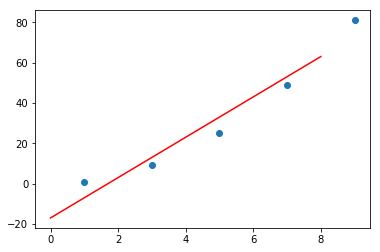

In [111]:
# SCIKIT LEARN - SVM
%matplotlib inline

from sklearn import linear_model
from sklearn import svm
from sklearn import neural_network
import numpy as np
from matplotlib import pyplot as plt

#_lr = linear_model.LinearRegression()
_svm = svm.SVC()
#_nn = neural_network.MLPRegressor(max_iter=100)

arr_nums_train = range(1,10,2)
arr_nums_test = range(0,10,2)

x_train = np.transpose([arr_nums_train])
y_train = np.power(arr_nums_train,2)

x_test = np.transpose([arr_nums_test])

#_lr.fit(x_train,y_train)
_svm.fit(x_train,y_train)
#_nn.fit(x_train,y_train)

val_to_predict = 6

#lr_prediction  = _lr.predict(x_test)
svm_prediction = _svm.predict(x_test)
#nn_prediction  = _nn.predict(x_test)

#print("prediccion rl", lr_prediction)
print("prediccion svm", svm_prediction)
#print("prediccion nn", nn_prediction)

plt.scatter(x_train, y_train)
plt.plot(x_test, lr_prediction, color='r')


In [114]:
print x_train
print y_train

[[1]
 [3]
 [5]
 [7]
 [9]]
[[ 1]
 [ 9]
 [25]
 [49]
 [81]]


In [4]:
##### TESTING MAIN FUNCTION ########

import cv2
import numpy as np

featuresX = []
featuresY = []

ruta_imagen = "images/signatures/drsc/legit_1"
extension_imagen = ".jpg"
image = cv2.imread(ruta_imagen + extension_imagen)
image = preprocess(image, True)
cv2.imshow('Signature PreProcessed', image)
cv2.waitKey(0)

img_dilated = dilatex5(image)
cv2.imshow('Signature Dilated x5', img_dilated)
cv2.imwrite(ruta_imagen+"_x5"+extension_imagen, img_dilated)
cv2.waitKey(0)

cv2.destroyAllWindows()


In [16]:
cv2.COLOR_BGR2GRAY

6